## Checking the performance of quality metric from hembedder 

In [4]:
#trustworthiness --> sklearn
# distance correlation correlation --> zelf chefffen
# knn-overlap - distance curve and integral
# poincarre


### knn_overlap -> find knn in true space random sample. Then embedding do the same for indices -> jaccard score
__author__ = "Bram van ES", "Huibert-Jan Joosse", "Chontira Chumsaeng"

from setup_cc import *
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hembedder.utils._cpython._metrics_cy as metrics_cy

from tqdm import tqdm
from hembedder.utils import quality_metrics as qm

from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

In [5]:
from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

def get_scores(embedded_info): 
    #Get performance metrics for each subsampled embedder
    evaluate_n_n_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, n_neighbours=15, metric='manhattan')
    evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan')

    evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
            'dcor_1': evaluate._return_distance_correlation,
            'neighbor_kept_50' : evaluate.neighbor_kept_ratio_eval,
            'neighbor_kept' : evaluate_n_n_default.neighbor_kept_ratio_eval,
            'dcor_2': evaluate_n_n_default._return_distance_correlation,
            'Trustworthiness': evaluate._return_trustworthiness,
            'LCMC_Q_matrix': evaluate._return_LCMC,
            'Trustworthiness_Q_matrix': evaluate._return_Qtrustworthiness,
            'Continuit_Q_matrix':  evaluate._return_Qcontinuity,
            'nMRRE_Q_matrix' : evaluate._return_nMRRE,
            'vMRRE_Q_matrix' : evaluate._return_vMRRE,
            'Qnx_crm_Q_matrix': evaluate._return_qnx_crm,
            'Rnx_crm_Q_matrix': evaluate._return_rnx_crm,
            'Qnx_auc_crm_Q_matrix': evaluate._return_rnx_auc_crm}
    embedded_info.update({'evaluators': evaluators})
    scores = metrics_scores_iter(**embedded_info)
    return scores

def get_embedded_data(X,parameter:dict, embedder,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    X = np.asarray(X, dtype=np.float32)
    embedded_data = []
    times = []
    for iter in range(num_iter):
        start = time.time()
        sub = numpy_sampling(X, subsampling)
        # Evaluate randomly selected hyperparameters
        CD_scaled = sub.copy()
    
        scaler = StandardScaler()
        CD_scaled = scaler.fit_transform(sub)
        # Create a dictionary for later reference in multi-thread
        indexes_metrics= subsampling_return_indexes(sub, 5000)
        emb_dict = {"original" : sub[indexes_metrics],
                    "embedded" : embedder(**parameter).fit_transform(CD_scaled).astype(np.float32)[indexes_metrics]}
        embedded_data.append(emb_dict)
        #times.append(time.time()-start)
    return embedded_data

def get_embedded_without_embedding(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = []
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"x" : X[sample_index],
                    "output" : X_embedded[sample_index],
                    "Q":compute_coranking_matrix(X[sample_index],\
                    X_embedded[sample_index], leave = False).astype(np.int32)}
        embedded_data.append(emb_dict)
        
    return embedded_data

def metrics_scores_iter(
    x: np.array,
    output: np.array,
    evaluators: dict,
    **args
):
    """Calculates scores for embedder using different metrics (evaluators).

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = {}
    for name, metric in evaluators.items():
        if("Q" in args.keys() and "Q_matrix" in name):
            results.update({name: metric(x, output,args["Q"])})
        else:
            results.update({name: metric(x, output)})
    return results


def get_embedded_without_embedding_queue(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = queue.Queue()
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        print(len(sample_index))
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"original" : X[sample_index],
                    "embedded" : X_embedded[sample_index]}
        embedded_data.put(emb_dict)
        
    return embedded_data

def numpy_sampling(X, subsampling):  
    n_data = len(X) 
    idx = np.arange(n_data) 
    np.random.shuffle(idx) 
    return X[idx[: subsampling],:] 

def subsampling_return_indexes(X, subsampling):
    rand = np.random.default_rng()
    n_data = len(X) 
    subsampling = min(n_data, subsampling) 
    return  rand.choice(np.arange(n_data), size=subsampling, replace=False)

In [6]:
sample_index = cell_dyn_with_labels.sample(50000).index
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
indexes_metrics= subsampling_return_indexes(sampled_cd, 10000)
age = np.array(cell_dyn_with_labels.age.loc[sample_index])

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import trimap
from sklearn.decomposition import PCA
import pacmap
import phate


metric = "manhattan"

embedder_3 = umap.UMAP(n_components=3,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_6 = umap.UMAP(n_components=6,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_15 = umap.UMAP(n_components=15,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_30 = umap.UMAP(n_components=30,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_60 = umap.UMAP(n_components=60,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)


trimap_model_3 = trimap.TRIMAP(n_dims=3,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_6 = trimap.TRIMAP(n_dims=6,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_15 = trimap.TRIMAP(n_dims=15,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_30 = trimap.TRIMAP(n_dims=30,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_60 = trimap.TRIMAP(n_dims=60,n_inliers=50,n_outliers=15, n_random=10, distance=metric)

pacmap_model_3 = pacmap.PaCMAP(n_components=3,n_neighbors=50, distance=metric,MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_6 = pacmap.PaCMAP(n_components=6,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_15 = pacmap.PaCMAP(n_components=15,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_30 = pacmap.PaCMAP(n_components=30,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)


pca_model_3 = PCA(n_components=3,whiten=False)
pca_model_6 = PCA(n_components=6,whiten=False)
pca_model_15 = PCA(n_components=15,whiten=False)
pca_model_30 = PCA(n_components=30,whiten=False)
pca_model_60 = PCA(n_components=60,whiten=False)


phate_model_3 = phate.PHATE(n_components=3, knn = 50, knn_dist=metric)
phate_model_6 = phate.PHATE(n_components=6, knn = 50, knn_dist=metric)
phate_model_15 = phate.PHATE(n_components=15, knn = 50, knn_dist=metric)
phate_model_30 = phate.PHATE(n_components=30, knn = 50, knn_dist=metric)

## for loop per model

### UMAP

In [63]:
from scipy.signal import resample
performance_dict_umap = {}
for model in tqdm([embedder_3, embedder_6, embedder_15,embedder_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_umap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [53:27<00:00, 801.86s/it]


In [9]:
import json

with open("../data/umap_performance.json","w") as f:
    json.dump(performance_dict_umap,f)

### TriMAP

In [64]:
from scipy.signal import resample
performance_dict_trimap = {}
for model in tqdm([trimap_model_3, trimap_model_6, trimap_model_15,trimap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_trimap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [2:03:43<00:00, 1856.00s/it]


In [11]:
with open("../data/trimap_performance.json","w") as f:
    json.dump(performance_dict_trimap,f)

### PaCMAP

In [65]:
performance_dict_pacmap = {}

for model in tqdm([pacmap_model_3, pacmap_model_6, pacmap_model_15, pacmap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pacmap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),
            ('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix),
            ('Qnx_crm',Qnx_crm_Q_matrix), ('rnx_crm',Rnx_crm_Q_matrix), 
            ('Qnx_auc',Qnx_auc_crm_Q_matrix)
            ]
        })
    


100%|██████████| 4/4 [26:21<00:00, 395.35s/it]


In [13]:
with open("../data/pacmap_performance.json","w") as f:
    json.dump(performance_dict_pacmap,f)

### PCA

In [66]:
from scipy.signal import resample
performance_dict_pca = {}
for model in tqdm([pca_model_3,pca_model_6, pca_model_15,pca_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.transform(sampled_cd[indexes_metrics]).astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pca.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [02:29<00:00, 37.46s/it]


In [15]:
with open("../data/pca_performance.json","w") as f:
    json.dump(performance_dict_pca,f)

### Phate

In [37]:
from scipy.signal import resample
performance_dict_phate = {}
for model in tqdm([phate_model_3, phate_model_6, phate_model_15, phate_model_30]):

    norm_x = StandardScaler().fit_transform(sampled_cd)
    eval_emb = model.fit_transform(norm_x)[indexes_metrics].astype(np.float32)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_phate.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),
            ('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix),
            ('Qnx_crm',Qnx_crm_Q_matrix), ('rnx_crm',Rnx_crm_Q_matrix),
            ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


  0%|          | 0/4 [00:00<?, ?it/s]

Calculating PHATE...
  Running PHATE on 50000 observations and 98 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 548.08 seconds.
    Calculating affinities...
    Calculated affinities in 1.87 seconds.
  Calculated graph and diffusion operator in 550.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 28.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.34 seconds.
  Calculated landmark operator in 40.97 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 3.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.04 seconds.
  Calculating metric MDS...


c:\ProgramData\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 116.52 seconds.
Calculated PHATE in 712.34 seconds.


 25%|██▌       | 1/4 [12:30<37:30, 750.16s/it]

Calculating PHATE...
  Running PHATE on 50000 observations and 98 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 516.30 seconds.
    Calculating affinities...
    Calculated affinities in 1.76 seconds.
  Calculated graph and diffusion operator in 518.80 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 26.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.54 seconds.
  Calculated landmark operator in 39.61 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 2.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.68 seconds.
  Calculating metric MDS...


c:\ProgramData\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 375.76 seconds.
Calculated PHATE in 937.57 seconds.


 50%|█████     | 2/4 [28:52<29:33, 886.97s/it]

Calculating PHATE...
  Running PHATE on 50000 observations and 98 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 542.45 seconds.
    Calculating affinities...
    Calculated affinities in 1.83 seconds.
  Calculated graph and diffusion operator in 545.09 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 28.83 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.56 seconds.
  Calculated landmark operator in 40.18 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 3.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.75 seconds.
  Calculating metric MDS...


c:\ProgramData\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 367.64 seconds.
Calculated PHATE in 956.78 seconds.


 75%|███████▌  | 3/4 [45:27<15:36, 936.18s/it]

Calculating PHATE...
  Running PHATE on 50000 observations and 98 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 526.31 seconds.
    Calculating affinities...
    Calculated affinities in 1.76 seconds.
  Calculated graph and diffusion operator in 528.84 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 26.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.09 seconds.
  Calculated landmark operator in 37.89 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 2.67 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.61 seconds.
  Calculating metric MDS...


c:\ProgramData\Miniconda3\envs\embcelldyn\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 346.87 seconds.
Calculated PHATE in 916.97 seconds.


100%|██████████| 4/4 [1:01:21<00:00, 920.33s/it]


### comparing results

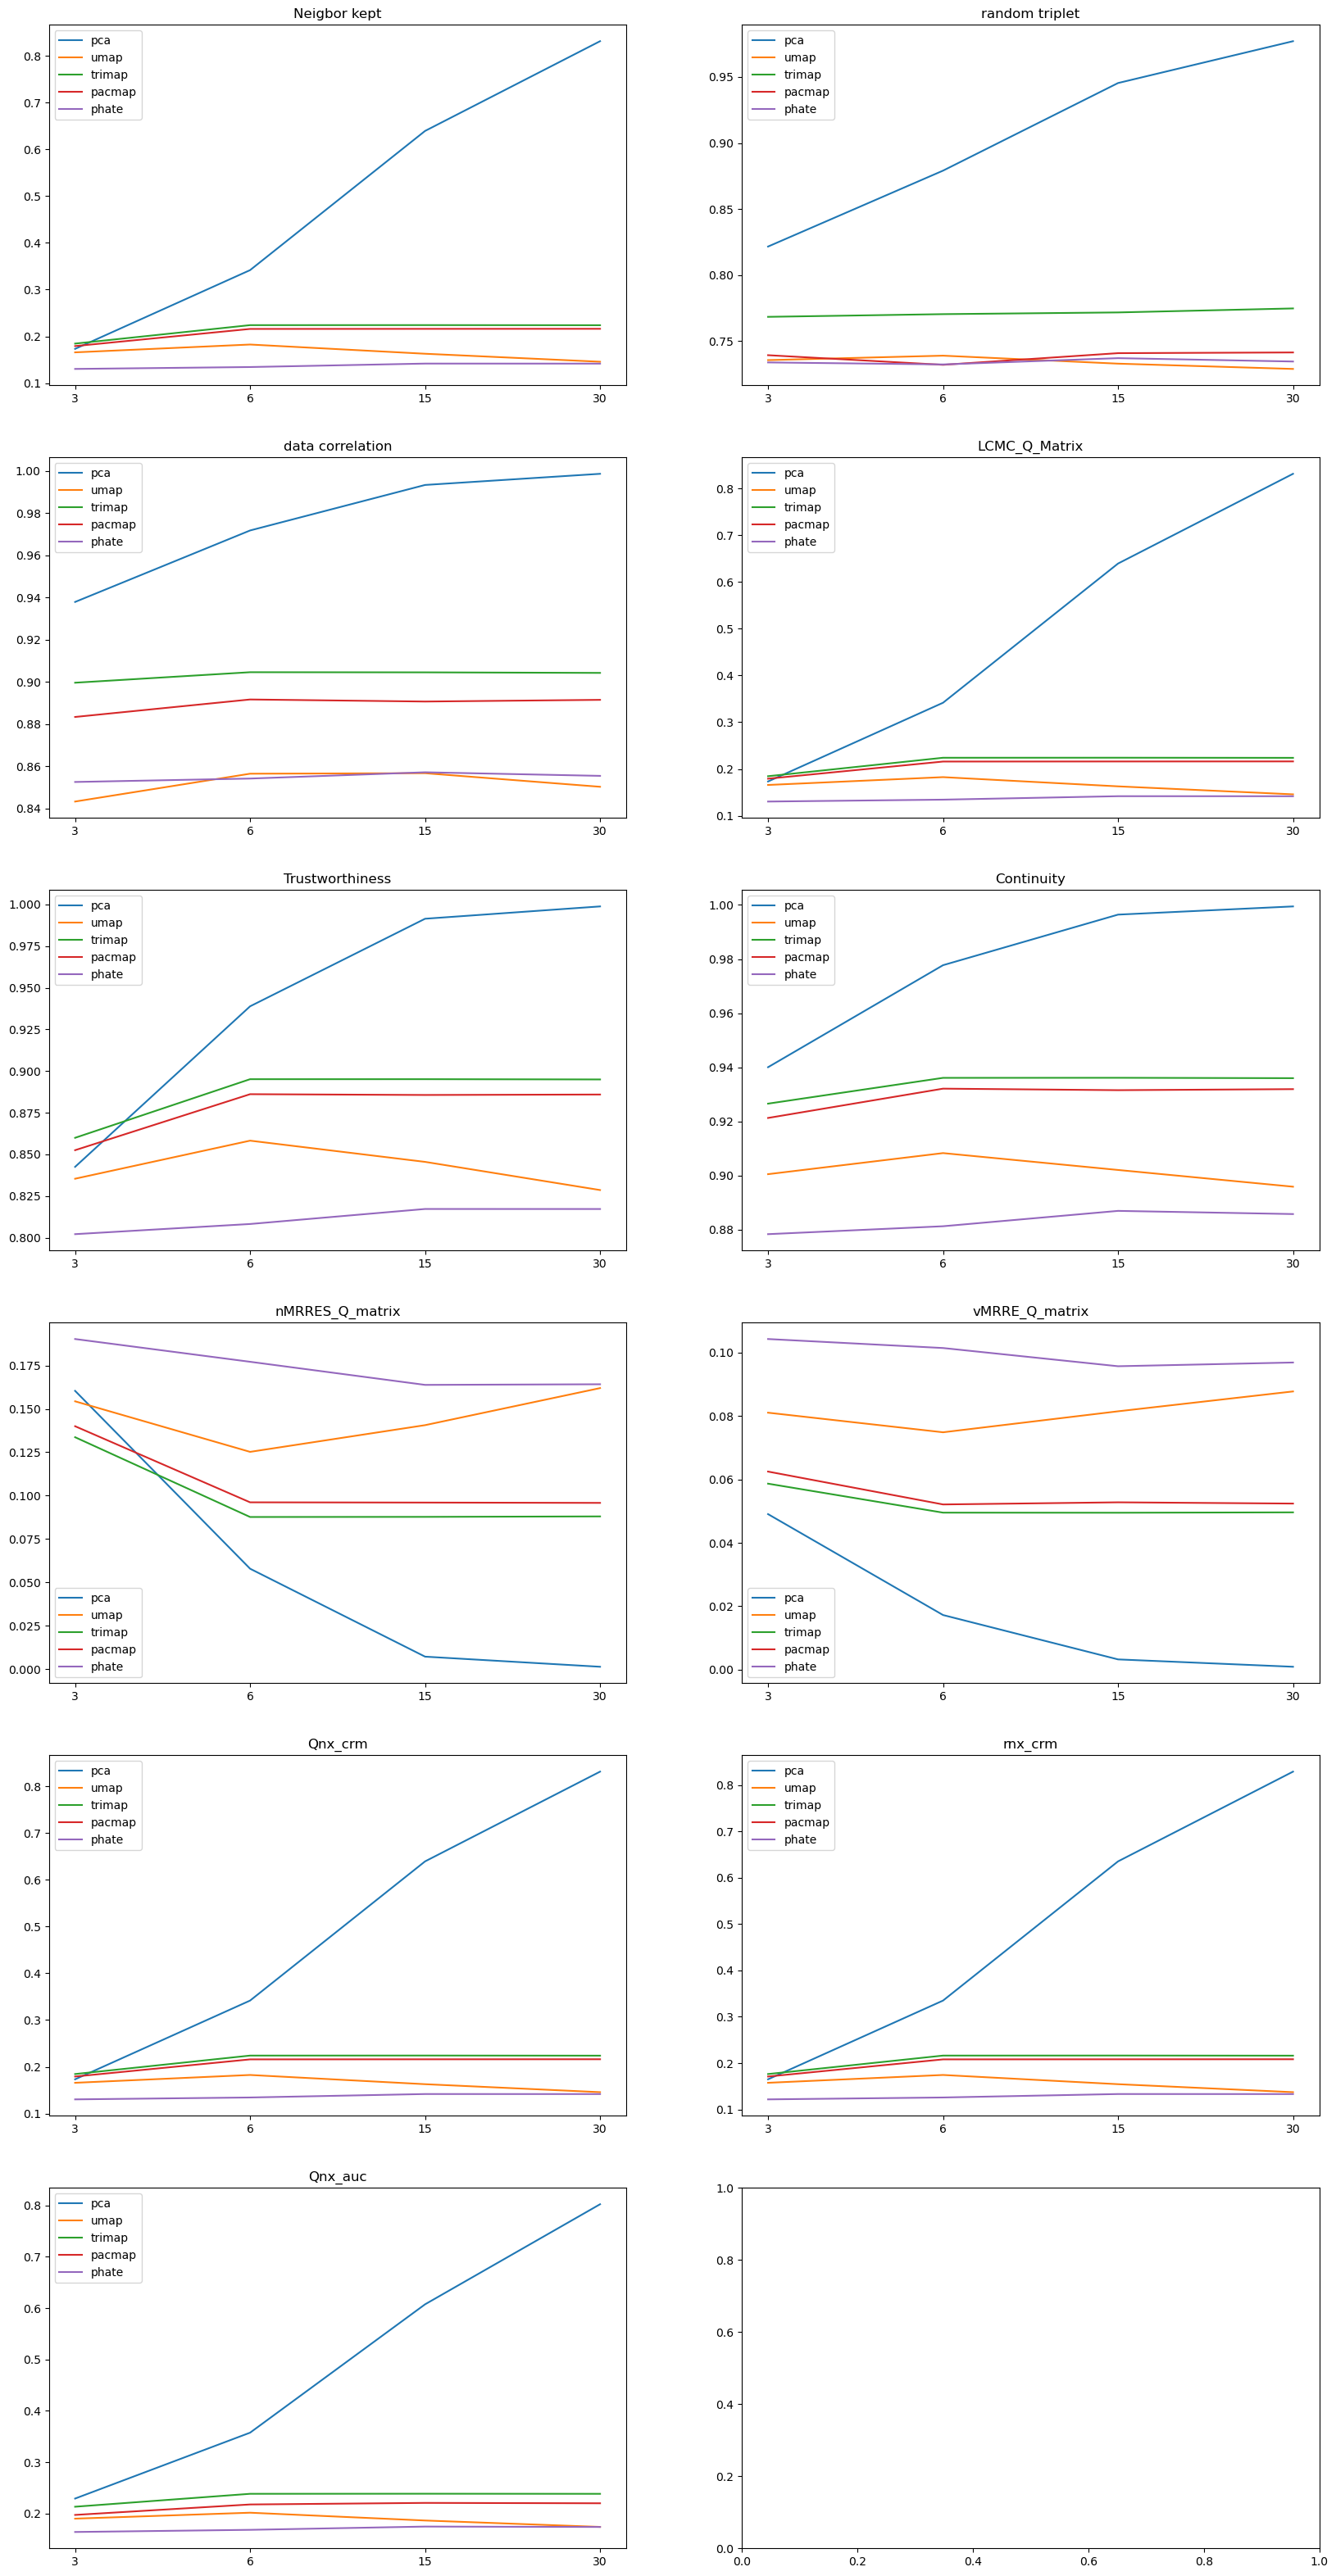

In [68]:
import re

fig, ax = plt.subplots(6,2,figsize = (20,40))

labels = ['pca','umap','trimap','pacmap','phate']

for n,performances in enumerate([performance_dict_pca,performance_dict_umap,performance_dict_trimap,performance_dict_pacmap,performance_dict_phate]):
    perf_to_plot = None
    for key,value in performances.items():
        if perf_to_plot == None:
            perf_to_plot = {k[0]:[] for k in value}
            perf_to_plot.update({'n_dims':[]})
        for metric,score in value:
            perf_to_plot[metric].append(score)
        perf_to_plot['n_dims'].append(re.search(r"\d+",key).group())
        
    i,j = 0,0

    for metric in perf_to_plot.keys():
        if metric != "n_dims":
            ax[j,i].plot(perf_to_plot['n_dims'],perf_to_plot[metric], label = labels[n])
            ax[j,i].legend()
            ax[j,i].set_title(metric)
            j = j+1 if i == 1 else j
            i = 0 if i == 1 else 1
            

## KMeans Clustering 

In [17]:
from sklearn.cluster import BisectingKMeans as BKM
from hdbscan import HDBSCAN

### pca

In [69]:
X = pca_model_6.transform(sampled_cd).astype(np.float32)
# bkm_pca6 = BKM().fit(X=X)
labels_pca = HDBSCAN().fit_predict(X)

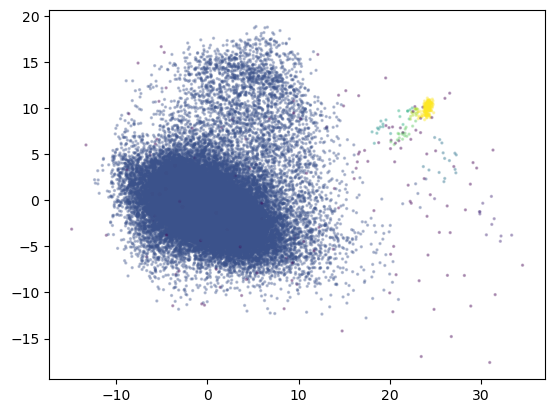

In [70]:
plt.scatter(X[:,0],X[:,1], c= labels_pca, s=2, alpha = 0.3)

### UMAP

In [71]:
X=embedder_6.embedding_
# bkm_umap6 = BKM().fit(X=X)
labels_umap = HDBSCAN().fit_predict(X)

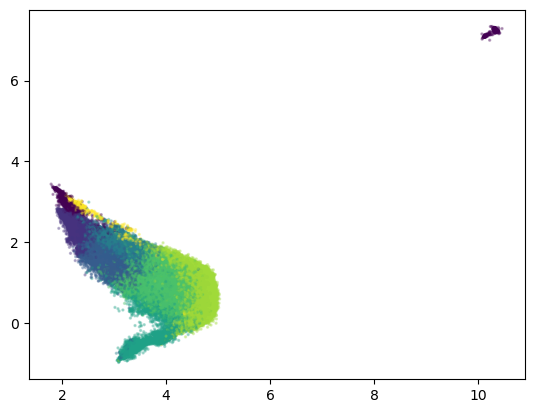

In [72]:
plt.scatter(X[:,0],X[:,1], c= labels_orig, s=2, alpha = 0.3)

### TriMaP


In [73]:
X=trimap_model_6.embedding_
# bkm_trimap6 = BKM().fit(X=X)
labels_trimap = HDBSCAN().fit_predict(X)

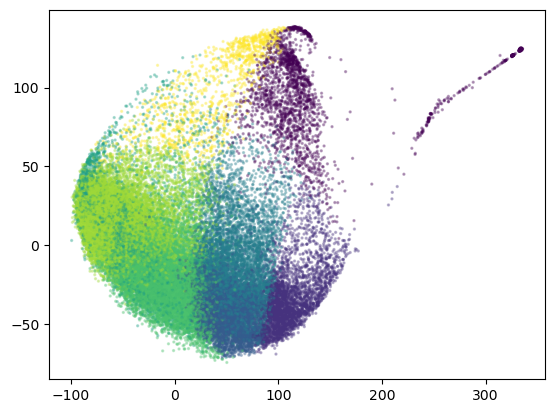

In [74]:
plt.scatter(X[:,0],X[:,1], c= labels_orig, s=2, alpha = 0.3)

### Pacmap

In [75]:
X=pacmap_model_6.embedding_
# bkm_pacmap6 = BKM().fit(X=X)
labels_pacmap = HDBSCAN().fit_predict(X)

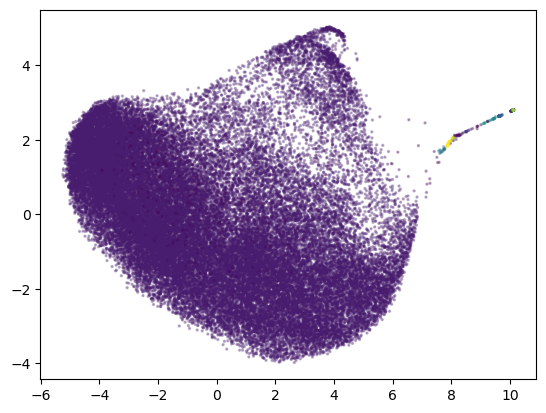

In [76]:
plt.scatter(X[:,0],X[:,1], c= labels_pacmap, s=2, alpha = 0.3)

### Phate

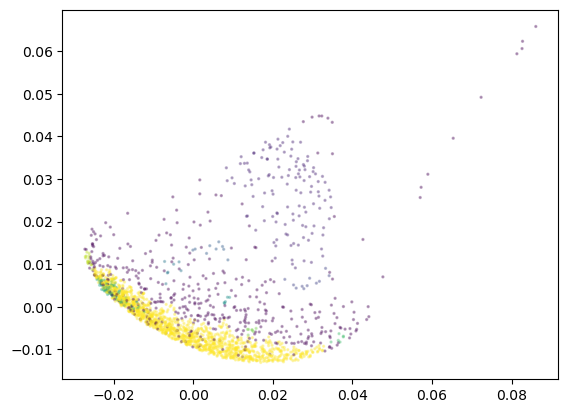

In [77]:
from sklearn.preprocessing import StandardScaler

X= phate_model_6.embedding
# bmk_orig = BKM().fit(X=X)
labels_phate = HDBSCAN().fit_predict(X)

plt.scatter(
    X[:,0],
    X[:,1], 
    c= labels_phate, 
    s=2, 
    alpha = 0.3)

### original_data

In [88]:
from sklearn.preprocessing import StandardScaler

X=StandardScaler().fit_transform(sampled_cd)

bmk_orig = BKM(bisecting_strategy='biggest_inertia').fit(X=X)
labels_orig = bmk_orig.predict(X)

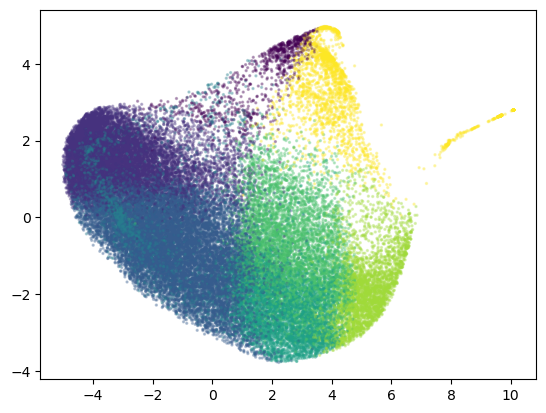

In [93]:
X_plot=pacmap_model_6.transform(X,X)
plt.scatter(
    X_plot[:,0],
    X_plot[:,1], 
    c= labels_orig, 
    s=2, 
    alpha = 0.3)

### check cluster distances

In [59]:
df = pd.DataFrame(sampled_cd,columns = cols_c_b_combo)
df['label'] = labels_orig

In [100]:
metric = 'manhattan'
X = StandardScaler().fit_transform(sampled_cd)
X_pca = pca_model_6.transform(X)
X_umap = embedder_6.embedding_
X_trimap = trimap_model_6.embedding_
X_pacmap = pacmap_model_6.embedding_
X_phate = phate_model_6.transform(X)

cluster_eval_pca = {}
cluster_eval_umap = {}
cluster_eval_trimap = {}
cluster_eval_pacmap = {}
cluster_eval_phate = {}

for label in tqdm(df.label.unique()):
    index = df.loc[df.label == label].index
    for n,embedding in enumerate([X_pca,X_umap,X_trimap,X_pacmap,X_phate]):
        evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
        df_clust = df.loc[index].to_numpy(dtype = np.float32)
        emb_clust = embedding[index]
        Qmatrix = evaluate._get_coranking_matrix(
            X_org=df_clust, X_emb=emb_clust, backend="numba"
            )
        
        dat_cor = evaluate._return_distance_correlation(df_clust,emb_clust)
        random_triplet = evaluate.random_triplet_eval(df_clust,emb_clust)

        if n == 0:
            cluster_eval_pca.update({label:[dat_cor,random_triplet]})
        elif n == 1:
            cluster_eval_umap.update({label:[dat_cor,random_triplet]})
        elif n == 2:
            cluster_eval_trimap.update({label:[dat_cor,random_triplet]})
        elif n == 3:
            cluster_eval_pacmap.update({label:[dat_cor,random_triplet]})
        else:
            cluster_eval_phate.update({label:[dat_cor,random_triplet]})
        

100%|██████████| 8/8 [18:14<00:00, 136.84s/it]


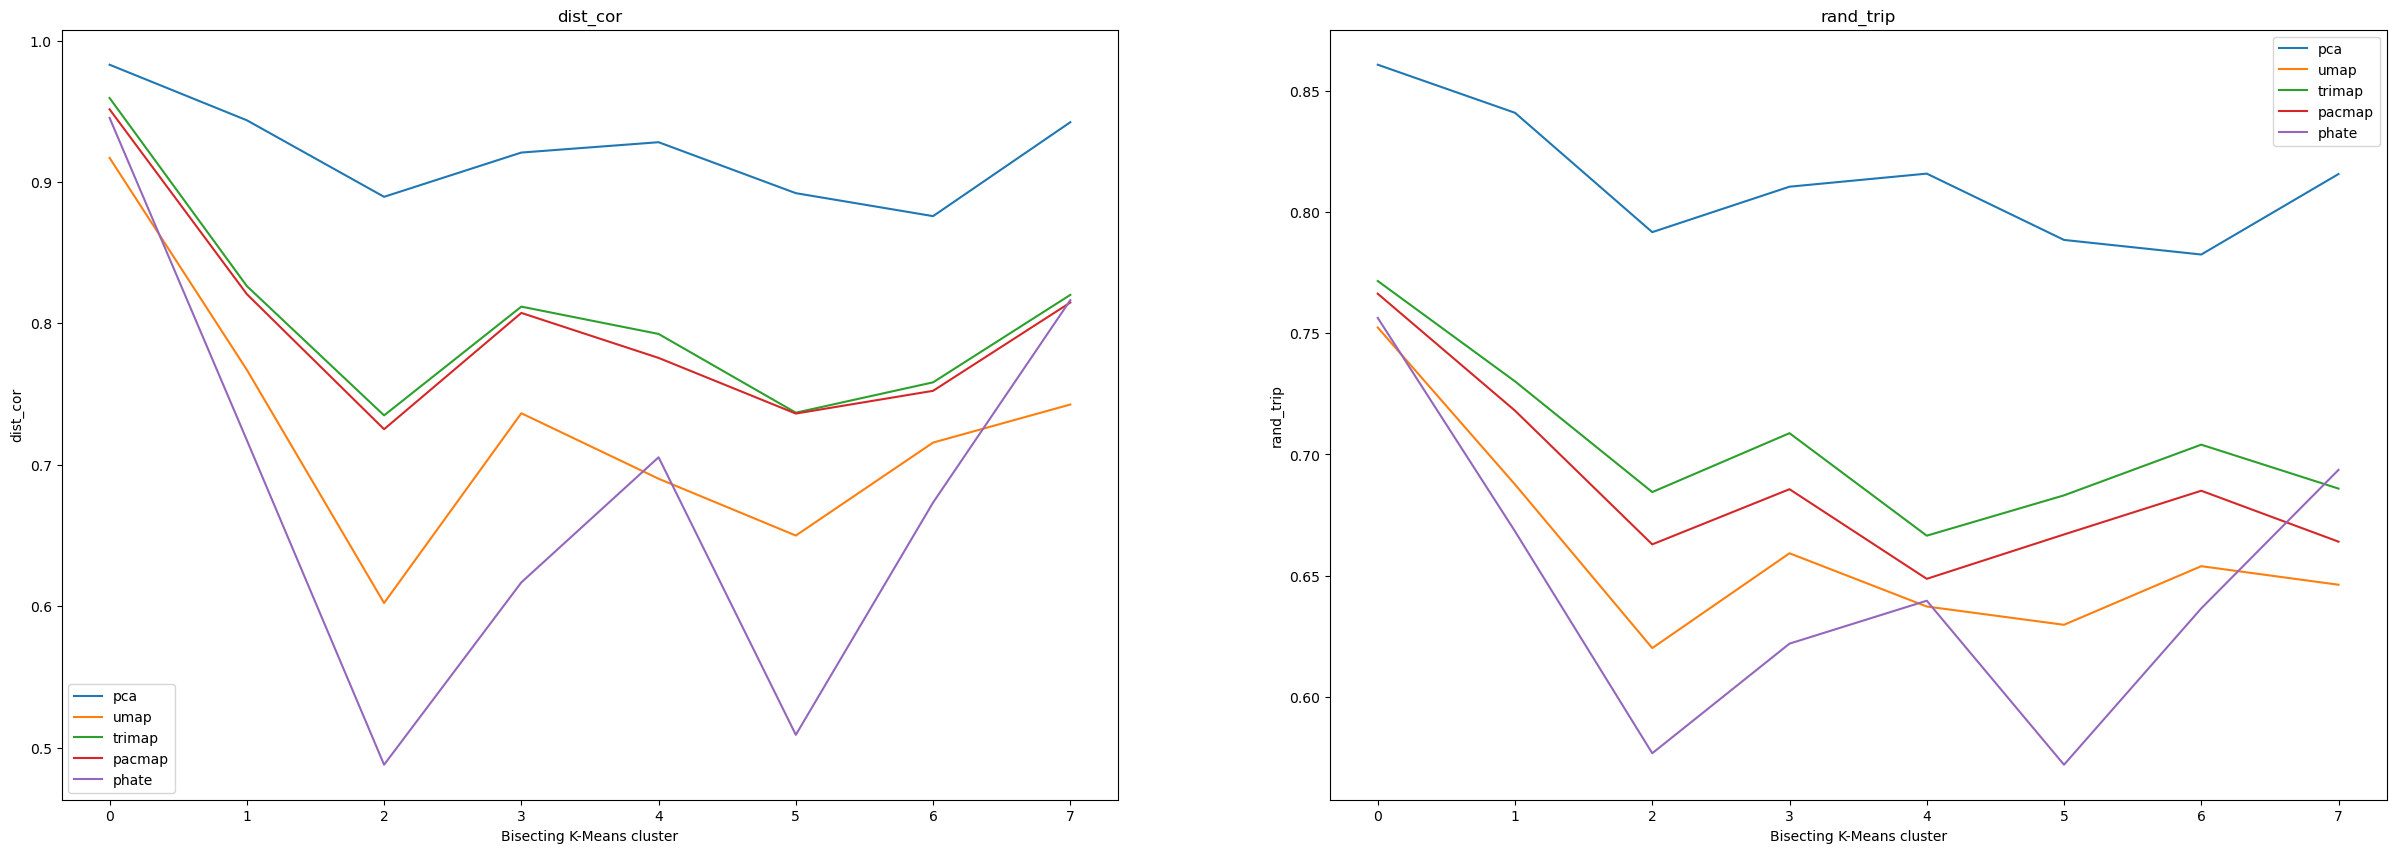

In [101]:

fig,ax = plt.subplots(1,2,figsize = (30,10))
for emb,eval_dict in {k:v for k,v  in zip(['pca','umap','trimap','pacmap','phate'],[cluster_eval_pca,cluster_eval_umap,cluster_eval_trimap,cluster_eval_pacmap,cluster_eval_phate])}.items():
    for i,metric in enumerate(['dist_cor','rand_trip']):
        ax[i].plot(sorted(eval_dict),[eval_dict[key][i] for key in sorted(eval_dict)],label = emb)
        ax[i].legend()
        ax[i].set_xlabel("Bisecting K-Means cluster")
        ax[i].set_ylabel(metric)
        ax[i].set_title(metric)

#### KMeans Cluster center preservation

In [105]:
km_centers_pca = pca_model_6.transform(bmk_orig.cluster_centers_)
km_centers_umap = embedder_6.transform(bmk_orig.cluster_centers_)
km_centers_pacmap = pacmap_model_6.transform(bmk_orig.cluster_centers_, sampled_cd)
km_centers_phate = phate_model_6.transform(bmk_orig.cluster_centers_)

Calculating KNN search...
Calculated KNN search in 0.10 seconds.
Calculating affinities...


c:\ProgramData\Miniconda3\envs\embcelldyn\lib\site-packages\phate\phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [103]:
import dcor

In [117]:
print(f"pca_dcor {dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_pca):.5f}")
print(f"umap_dcor {dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_umap):.5f}")
print(f"pacmap_dcor {dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_pacmap):.5f}")
print(f"phate_dcor {dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_phate):.5f}")

pca_dcor 0.99985
umap_dcor 0.94559
pacmap_dcor 0.96014
phate_dcor 0.96328
